# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import time
import re
import string
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import KNNImputer
from wordcloud import WordCloud
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/BT4012/fake_job_postings.csv')



Mounted at /content/drive


In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Data Cleaning


In [4]:
# Print data types of each column
print("Data Types:")
print(df.dtypes)

# Print number of unique values in each column
print("\nNumber of Unique Values:")
print(df.nunique())

Data Types:
job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Number of Unique Values:
job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
re

From the above output, we can classify our categorical variables "telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education".

The text data columns would include "title", "company_profile", "description", "requirements", "benefits", "industry", "function", "department".

## Handling Location Data

Since values in the ```location``` column consist of more than 1 relevant value, we will split the data. The final value taken into account would be the country of origin of the posting.

In [5]:
# Transform 'location' to keep only the country code
df['location'] = df['location'].str.split(',').str[0]

# Print the unique values in 'location'
unique_locations = df['location'].unique()
print("Unique values in 'location':")
print(unique_locations)

unique_locations = df['location'].nunique()
print("Unique values in 'location':")
print(unique_locations)

Unique values in 'location':
['US' 'NZ' 'DE' 'GB' 'AU' 'SG' 'IL' 'AE' 'CA' 'IN' 'EG' 'PL' 'GR' nan 'PK'
 'BE' 'BR' 'SA' 'DK' 'RU' 'ZA' 'CY' 'HK' 'TR' 'IE' 'LT' 'JP' 'NL' 'AT'
 'KR' 'FR' 'EE' 'TH' 'PA' 'KE' 'MU' 'MX' 'RO' 'MY' 'FI' 'CN' 'ES' 'SE'
 'CL' 'UA' 'QA' 'IT' 'LV' 'IQ' 'BG' 'PH' 'CZ' 'VI' 'MT' 'HU' 'BD' 'KW'
 'LU' 'NG' 'RS' 'BY' 'VN' 'ID' 'ZM' 'NO' 'BH' 'UG' 'CH' 'TT' 'SD' 'SK'
 'AR' 'TW' 'PT' 'PE' 'CO' 'IS' 'SI' 'MA' 'AM' 'TN' 'GH' 'AL' 'HR' 'CM'
 'SV' 'NI' 'LK' 'JM' 'KZ' 'KH']
Unique values in 'location':
90


## Handing Salary_Range Data


Since values in the ```Salary_range``` data is in the format of a range, we will handle it by splitting the ranges into a lower and upper bound. This creates two new columns, ```salary_lower_bound``` as well as ```salary_upper_bound```.

In [6]:
salary=df['salary_range'].apply(lambda x:str(x).strip().split('-'))
salary=salary.apply(pd.Series)

def int_conversion(x):
    try:
        return int(x)
    except:
        return 0

df['salary_lower_bound']=salary[0]
df['salary_lower_bound']=df['salary_lower_bound'].apply(int_conversion)
df['salary_upper_bound']=salary[1]
df['salary_upper_bound']=df['salary_upper_bound'].apply(int_conversion)

df.drop('salary_range', axis=1, inplace=True)

## Handling missing data

In [7]:
df_info = pd.DataFrame({
    'Number of Nulls': df.isnull().sum(),
    'Total Rows': df.shape[0],
})

# Add a column for the ratio of null values to total rows
df_info['Ratio'] = df_info['Number of Nulls'] / df_info['Total Rows']

# Display the DataFrame
print(df_info)

                     Number of Nulls  Total Rows     Ratio
job_id                             0       17880  0.000000
title                              0       17880  0.000000
location                         346       17880  0.019351
department                     11547       17880  0.645805
company_profile                 3308       17880  0.185011
description                        1       17880  0.000056
requirements                    2695       17880  0.150727
benefits                        7210       17880  0.403244
telecommuting                      0       17880  0.000000
has_company_logo                   0       17880  0.000000
has_questions                      0       17880  0.000000
employment_type                 3471       17880  0.194128
required_experience             7050       17880  0.394295
required_education              8105       17880  0.453300
industry                        4903       17880  0.274217
function                        6455       17880  0.3610

The column ```salary_range``` is missing 15012 (84.0%) rows, and ```employment type``` is missing 3471 (19.4%) rows. ```required_experience``` and ```required_education``` are missing 7050 (39.4%) and 8105 (45.3%) rows respectively. Columns "company_profile", "description", "requirements", "benefits", "industry", "function", and "department", are text data columns which will be concatenated and tokenized further on. Thus, we will not handle missing values for these columns.

To address the missing values in the non-textual data columns, we will investigate each individual column.

### Handling missing employment_type data

In [8]:
# Inspect existing values
print(df['employment_type'].unique())

['Other' 'Full-time' nan 'Part-time' 'Contract' 'Temporary']


It can be observed that there already exists the value 'Other' in employment_type column.

In [9]:
df[df['employment_type']=='Other'].head()

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_lower_bound,salary_upper_bound
0,1,Marketing Intern,US,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,0,0
177,178,Underwriter,US,Approvals Department,Crest Financial is one of the leading privatel...,"Crest Financial is a fun, energetic, successfu...",High school diploma or general education degre...,Medical/Dental benefits for full time employee...,0,1,1,Other,Entry level,High School or equivalent,Financial Services,NaN,0,0,0
289,290,"Intern with Google, Microsoft, Facebook and mo...",US,NaN,"StudyHall creates opportunities for college, u...",#URL_ab309fb672a2b26317bd303c09c3c6762986d45c2...,Your must have core skills in ONE of the follo...,-Build Portfolio-Earn Money (Part-time or full...,1,1,1,Other,Internship,Bachelor's Degree,Computer Software,Engineering,0,0,0
336,337,Sales Trainee,BE,Sales,Optimy is a fast-growing company that develops...,Optimy is a fast-growing company that develops...,Our ideal candidates have:- the ambition to ga...,An exciting work experience in a young and fas...,0,1,0,Other,Internship,High School or equivalent,Information Technology and Services,Sales,0,0,0
406,407,Paid Internship for Africa Program,NaN,Africa Program,Applied Memetics LLC is a professional service...,Applied Memetics LLC (AM LLC) is looking for a...,"- Knowledge of Africa, specifically of the Sah...",NaN,0,1,0,Other,Internship,Bachelor's Degree,Media Production,NaN,0,0,0


In [10]:
df[df['employment_type'].isna()].head()

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_lower_bound,salary_upper_bound
2,3,Commissioning Machinery Assistant (CMA),US,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
5,6,Accounting Clerk,US,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7,8,Lead Guest Service Specialist,US,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0,0,0
11,12,Talent Sourcer (6 months fixed-term contract),GB,HR,Want to build a 21st century financial service...,TransferWise is the clever new way to move mon...,We’re looking for someone who:Proven track rec...,You will join one of Europe’s most hotly tippe...,0,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
17,18,Southend-on-Sea Traineeships Under NAS 16-18 Y...,GB,NaN,Established on the principles that full time e...,Government funding is only available for 16-18...,16-18 year olds only due to government funding...,Career prospects.,0,1,1,NaN,NaN,NaN,NaN,NaN,0,0,0


In the rows where ```employment_type``` has the value 'Other', it can be observed from the ```title``` that the role actually takes on a range of more unique job types such as ```internships``` or ```trainees```. On inspection of rows where ```employment_type``` is 'Nan', the job title similarly states unique job types such as ```Traineeship``` and ```Assistant```. Thus, the rows with 'Nan' values could be categorised as 'Other'.

In [11]:
# standardise Not Applicable format
df['employment_type'] = df['employment_type'].replace(np.nan, 'Other')

### Handling missing salary data

In [12]:
# Inspecting rows where salary_range, and thus salary_lower_bound and salary_upper_bound is NA
print(df[(df['salary_lower_bound'] == 0) & (df['salary_upper_bound'] == 0)])

       job_id                                              title location  \
0           1                                   Marketing Intern       US   
1           2          Customer Service - Cloud Video Production       NZ   
2           3            Commissioning Machinery Assistant (CMA)       US   
3           4                  Account Executive - Washington DC       US   
4           5                                Bill Review Manager       US   
...       ...                                                ...      ...   
17875   17876                   Account Director - Distribution        CA   
17876   17877                                 Payroll Accountant       US   
17877   17878  Project Cost Control Staff Engineer - Cost Con...       US   
17878   17879                                   Graphic Designer       NG   
17879   17880                         Web Application Developers       NZ   

        department                                    company_profile  \
0 

It can be observed that the missing salary_range values are not obviously related due to other columns, and that there is no observable pattern to which they are missing. As such, we assume they are missing at random (MAR). We will use KNN-imputation to fill the missing columns. This will be done after Train-Test split to prevent data leakage.

### Handling missing required_experience data

In [13]:
# Inspect existing values in column
df['required_experience'].unique()

array(['Internship', 'Not Applicable', nan, 'Mid-Senior level',
       'Associate', 'Entry level', 'Executive', 'Director'], dtype=object)

It can be observed that there already exists the value 'Not Applicable' in the column.

In [14]:
df[df['required_experience']=='Not Applicable'].head()

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_lower_bound,salary_upper_bound
1,2,Customer Service - Cloud Video Production,NZ,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,0,0
13,14,Installers,US,NaN,Growing event production company providing sta...,"Event Industry Installers Needed!! (Orlando, F...","Valid driver's license,Somewhat Clean driving ...",NaN,0,1,1,Full-time,Not Applicable,Unspecified,Events Services,Other,0,0,0
59,60,Product Visual Designer,US,NaN,"From the lands of Can Do, Roll Our Sleeves Up ...",Apcera is revolutionizing enterprise technolog...,RESPONSIBILITIES:Work with the UX architect's ...,Competitive salary &amp; equityGreat location ...,0,1,1,Full-time,Not Applicable,Unspecified,Information Technology and Services,Design,0,0,0
94,95,WF17 9LU Customer Service Apprenticeship under...,GB,NaN,Established on the principles that full time e...,This is fantastic opportunity for someone want...,Government funding is only available for 16-18...,Future Prospects,0,1,1,Full-time,Not Applicable,High School or equivalent,NaN,Administrative,0,0,0
107,108,Senior Developer at a Startup Investment Studio,GB,FP,"Based in Hoxton, London, Forward Partners are ...",Forward Partners invest in very early stage e-...,About youYou should be expert in one language ...,NaN,0,1,0,Full-time,Not Applicable,Unspecified,Venture Capital & Private Equity,Information Technology,0,50000,70000


In [15]:
df[df['required_experience'].isna()].head()

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_lower_bound,salary_upper_bound
2,3,Commissioning Machinery Assistant (CMA),US,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,Other,NaN,NaN,NaN,NaN,0,0,0
5,6,Accounting Clerk,US,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,Other,NaN,NaN,NaN,NaN,0,0,0
7,8,Lead Guest Service Specialist,US,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,Other,NaN,NaN,NaN,NaN,0,0,0
11,12,Talent Sourcer (6 months fixed-term contract),GB,HR,Want to build a 21st century financial service...,TransferWise is the clever new way to move mon...,We’re looking for someone who:Proven track rec...,You will join one of Europe’s most hotly tippe...,0,1,0,Other,NaN,NaN,NaN,NaN,0,0,0
17,18,Southend-on-Sea Traineeships Under NAS 16-18 Y...,GB,NaN,Established on the principles that full time e...,Government funding is only available for 16-18...,16-18 year olds only due to government funding...,Career prospects.,0,1,1,Other,NaN,NaN,NaN,NaN,0,0,0


On inspection of rows where ```required_experience``` is 'Not Applicable' compared to rows where it is 'Nan', there is no striking observable difference. Thus, the presence of 'Nan' values could suggest that they are actually 'Not Applicable'.

In [16]:
# standardise Not Applicable format
df['required_experience'] = df['required_experience'].replace(np.nan, 'Not Applicable')

### Handling missing required_education data

In [17]:
# Inspect existing values in column
df['required_education'].unique()

array([nan, "Bachelor's Degree", "Master's Degree",
       'High School or equivalent', 'Unspecified',
       'Some College Coursework Completed', 'Vocational', 'Certification',
       'Associate Degree', 'Professional', 'Doctorate',
       'Some High School Coursework', 'Vocational - Degree',
       'Vocational - HS Diploma'], dtype=object)

It can be observed that there already exists the value 'Unspecified' in the column.

In [18]:
df[df['required_education']=='Unspecified'].head()

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_lower_bound,salary_upper_bound
13,14,Installers,US,NaN,Growing event production company providing sta...,"Event Industry Installers Needed!! (Orlando, F...","Valid driver's license,Somewhat Clean driving ...",NaN,0,1,1,Full-time,Not Applicable,Unspecified,Events Services,Other,0,0,0
23,24,"Vice President, Sales and Sponsorship (Busines...",US,Businessfriend.com,"WDM Group is an innovative, forward thinking d...",#URL_eda2500ddcedb60957fcd7f5b164e092966f8c4e8...,"Job Requirements:A reputation as a ""go-getter""...",Businessfriend will offer a competitive six fi...,0,1,0,Full-time,Executive,Unspecified,Internet,Sales,0,100000,120000
31,32,Software Applications Specialist,US,NaN,NaN,"Day to Day-Install, upgrade and configure web-...",Must Have's3+ years of experience with web-bas...,"Medical, Dental, Vision, Life, Disability, Pre...",0,1,0,Full-time,Associate,Unspecified,Computer Software,Engineering,0,50000,65000
32,33,Craftsman Associate,US,Field,"We are an award-winning team of professionals,...",Construction: Entry-Level Craftsman Associate ...,Requirements: (Please do not apply if you do ...,Benefits: Hourly plus commissions. Work with ...,0,1,1,Full-time,Entry level,Unspecified,Construction,Other,0,0,0
59,60,Product Visual Designer,US,NaN,"From the lands of Can Do, Roll Our Sleeves Up ...",Apcera is revolutionizing enterprise technolog...,RESPONSIBILITIES:Work with the UX architect's ...,Competitive salary &amp; equityGreat location ...,0,1,1,Full-time,Not Applicable,Unspecified,Information Technology and Services,Design,0,0,0


In [19]:
df[df['required_education'].isna()].head()

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_lower_bound,salary_upper_bound
0,1,Marketing Intern,US,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,0,0
1,2,Customer Service - Cloud Video Production,NZ,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,0,0
2,3,Commissioning Machinery Assistant (CMA),US,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,Other,Not Applicable,NaN,NaN,NaN,0,0,0
5,6,Accounting Clerk,US,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,Other,Not Applicable,NaN,NaN,NaN,0,0,0
7,8,Lead Guest Service Specialist,US,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,Other,Not Applicable,NaN,NaN,NaN,0,0,0


Similar to ```required_experience```, rows with 'Unspecified' ```required_education``` have no striking observable difference to rows with value 'Nan'. Thus, the presence of 'Nan' values could suggest that they are actually 'Unspecified'.

In [20]:
# standardise Not Applicable format
df['required_education'] = df['required_education'].replace(np.nan, 'Unspecified')

# Exploratory Data Analysis


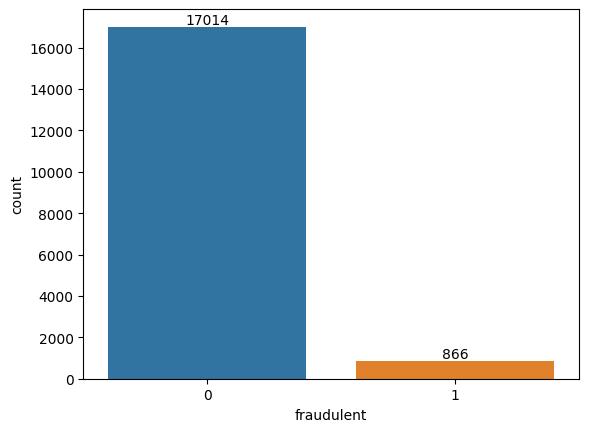

In [21]:
# shows imbalanced dataset
ax = sns.countplot(x="fraudulent", data=df)

for container in ax.containers:
    ax.bar_label(container)

plt.show()


There is significantly more non-fraudlent postings than fradulent, making this dataset imbalanced. We will account for it by performing ```Stratified Sampling```.

In [22]:
print(df['salary_lower_bound'].describe())

count    1.788000e+04
mean     8.192368e+04
std      7.055431e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.000000e+08
Name: salary_lower_bound, dtype: float64


In [23]:
print(df['salary_upper_bound'].describe())

count    1.788000e+04
mean     1.291116e+05
std      1.078792e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.200000e+09
Name: salary_upper_bound, dtype: float64


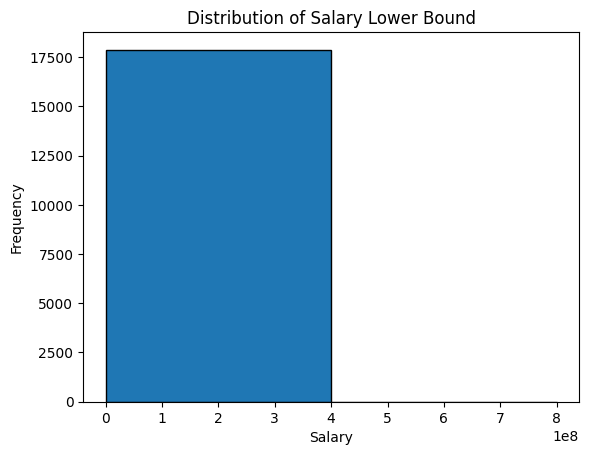

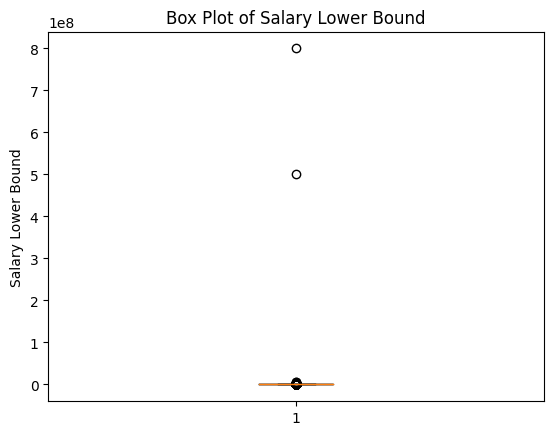

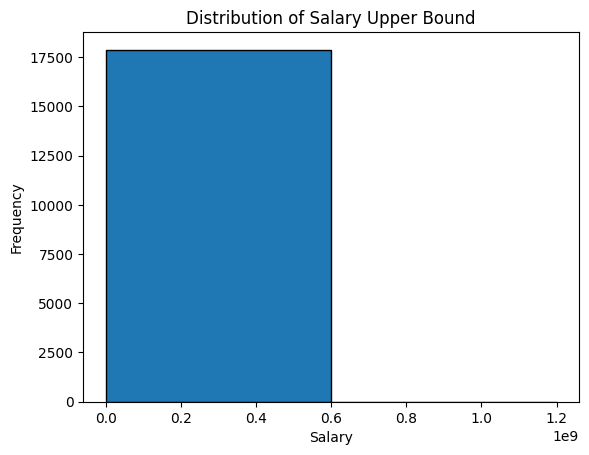

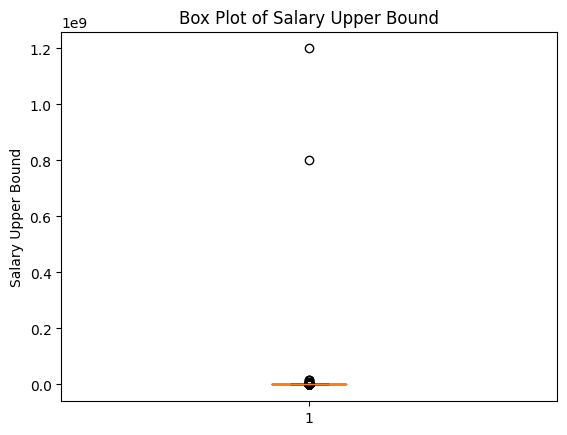

In [24]:
#analysis of numerical columns
plt.hist(df['salary_lower_bound'], bins=2, edgecolor='black')
plt.title('Distribution of Salary Lower Bound')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

plt.boxplot(df['salary_lower_bound'])
plt.title('Box Plot of Salary Lower Bound')
plt.ylabel('Salary Lower Bound')
plt.show()

plt.hist(df['salary_upper_bound'], bins=2, edgecolor='black')
plt.title('Distribution of Salary Upper Bound')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

plt.boxplot(df['salary_upper_bound'])
plt.title('Box Plot of Salary Upper Bound')
plt.ylabel('Salary Upper Bound')
plt.show()




It can be observed that there is no distinctive distribution of the salary lower and upper bound. Upon closer inspection, the numbers are too varied, ranging from 0 to 8.000000e+08 for the lower bound and 0 to 1.200000e+09 for the upper bound.

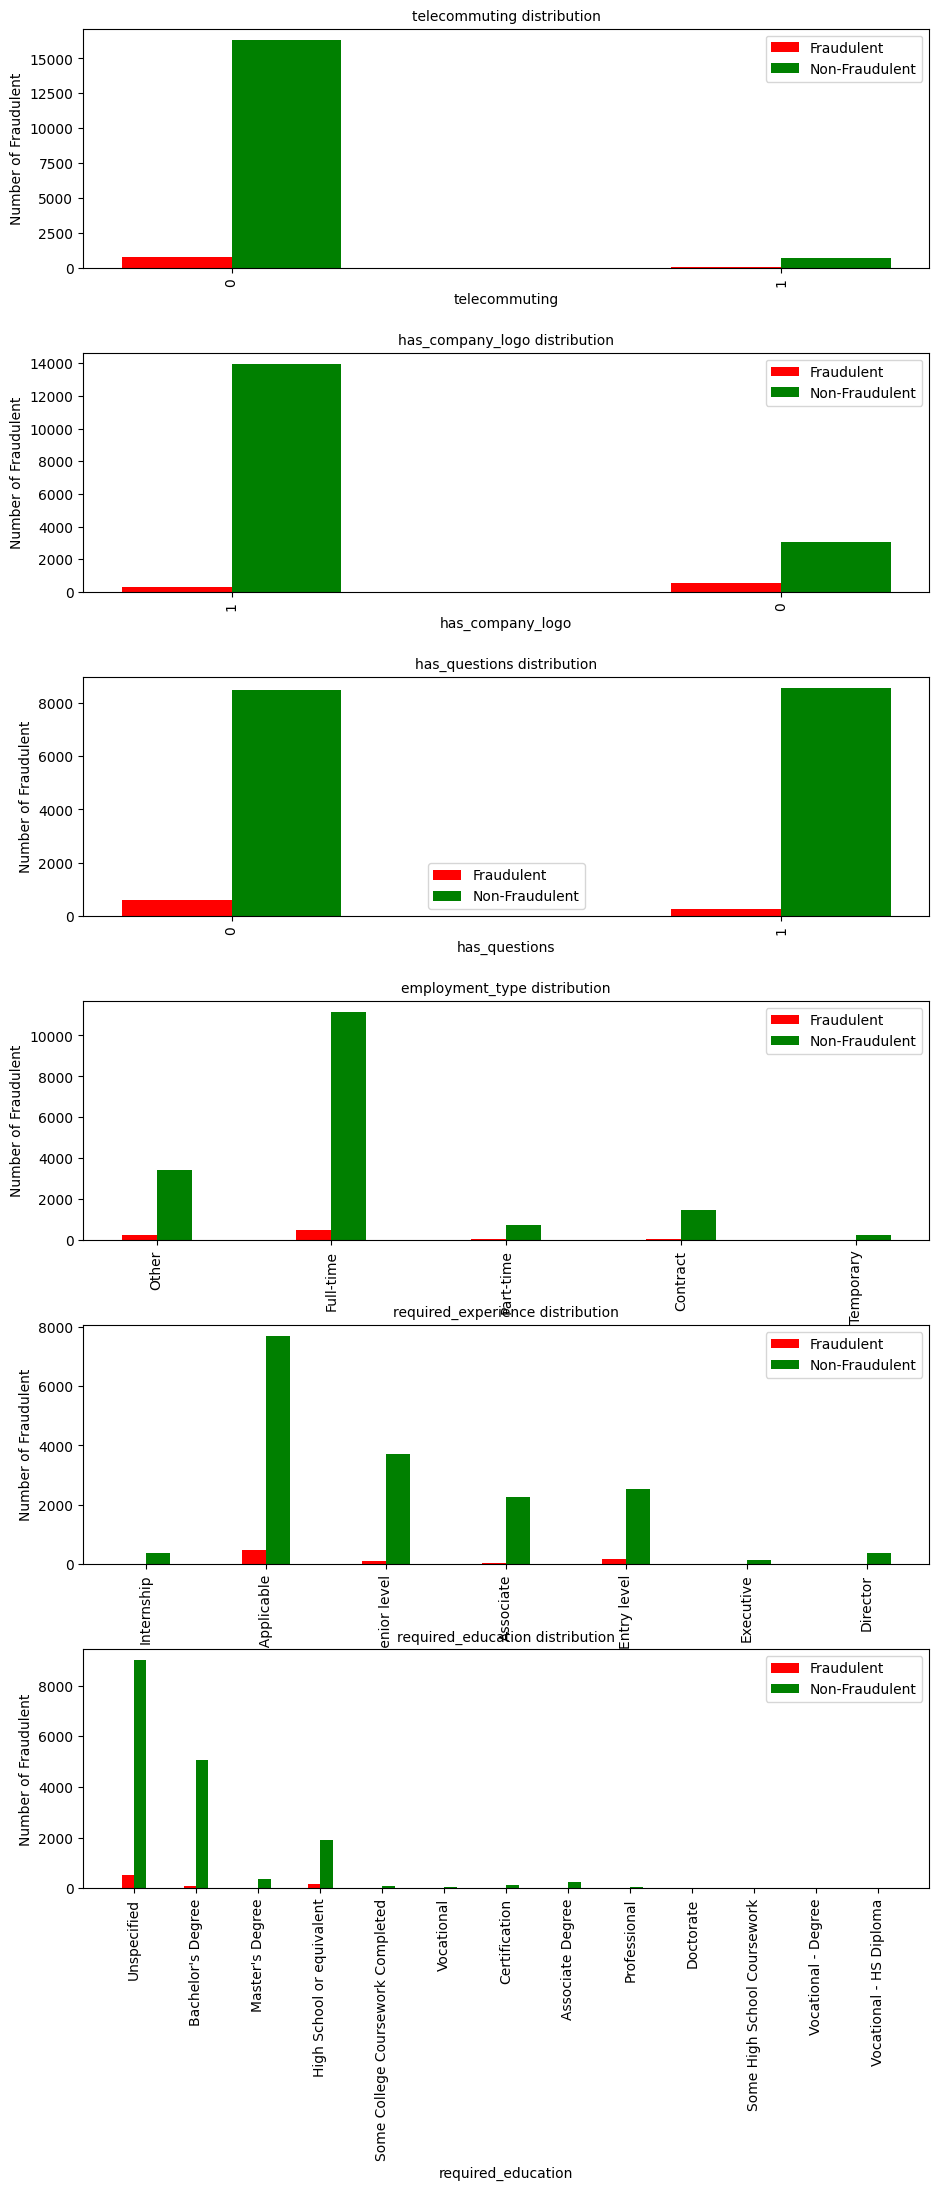

In [25]:
#analysis of categorical columns
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education"]

fig, axes = plt.subplots(len(cat_cols), 1, figsize=(10, 20))
fig.tight_layout(pad=4.0)

for i, col in enumerate(cat_cols):
    fraudulent_counts = df[df['fraudulent'] == 1].groupby(col).size()
    non_fraudulent_counts = df[df['fraudulent'] == 0].groupby(col).size()

    all_categories = df[col].unique()
    fraudulent_counts = fraudulent_counts.reindex(all_categories, fill_value=0)
    non_fraudulent_counts = non_fraudulent_counts.reindex(all_categories, fill_value=0)


    x = np.arange(len(all_categories))

    width = 0.2
    axes[i].bar(x - width/2, fraudulent_counts, width, label='Fraudulent', color='red')
    axes[i].bar(x + width/2, non_fraudulent_counts, width, label='Non-Fraudulent', color='green')

    axes[i].set_xticks(x)
    axes[i].set_xticklabels(all_categories, rotation=90)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Number of Fraudulent')
    axes[i].set_title(f'{col} distribution', fontsize=10)
    axes[i].legend()

plt.show()

In [26]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
# statistical analysis of textual columns

text_cols = ["title", "company_profile", "description", "department", "requirements", "benefits", "industry", "function"]
for col in text_cols:
    new_df = pd.DataFrame()
    new_df[col] = df[col]
    new_df['fraudulent'] = df['fraudulent']
    new_df = new_df.dropna()
    new_df['Word Count'] = df[col].apply(lambda x: len(str(x).split()))
    new_df['Character Count'] = df[col].apply(lambda x: len(str(x)))
    new_df['Sentence Count'] = df[col].apply(lambda x: len(nltk.sent_tokenize(str(x))))
    #new_df['Avg Word Length'] = new_df['Character Count'] / new_df['Word Count']
    #new_df['Avg Sentence Length'] = new_df['Word Count'] / new_df['Sentence Count']

    #print("Basic Statistics for {col}:")
    #print(new_df)
    print(f"Overall Statistics for {col}")
    print(f"Average Word Count: {new_df['Word Count'].mean()}")
    print(f"Average Character Count: {new_df['Character Count'].mean()}")
    print(f"Average Sentence Count: {new_df['Sentence Count'].mean()}")
    #print(f"Average Word Length: {new_df['Avg Word Length'].mean()}")
    #print(f"Average Sentence Length: {new_df['Avg Sentence Length'].mean()}")

    # word frequency analysis
    stop_words = stopwords.words('english')
    count_vectorizer = CountVectorizer(stop_words=stop_words)
    # Separating the cases based on 'fraudulent' flag
    for is_fraudulent in [0, 1]:
        # Filter the DataFrame based on the 'fraudulent' flag
        temp_df = new_df[new_df['fraudulent'] == is_fraudulent]

        # Generating word frequencies for the filtered data
        word_matrix = count_vectorizer.fit_transform(temp_df[col])
        # Convert the word_matrix to a DataFrame with appropriate column names
        word_frequencies = pd.DataFrame(word_matrix.sum(axis=0), columns=count_vectorizer.get_feature_names_out())
        # Transpose the DataFrame and name the frequency column
        word_frequencies = word_frequencies.T
        word_frequencies.columns = ['Frequency']
        word_frequencies = word_frequencies.sort_values(by='Frequency', ascending=False)

        # Generating the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies.to_dict()['Frequency'])

        # Plotting the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {"Non-Fraudulent" if is_fraudulent == 0 else "Fraudulent"} Cases in {col}')
        plt.show()


    fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(10, 6))
    length=new_df[new_df["fraudulent"]==0]['Word Count']
    ax1.hist(length,bins = 20, color='green')
    ax1.set_title('Not fraudulent')
    length=new_df[new_df["fraudulent"]==1]['Word Count']
    ax2.hist(length, bins = 20, color='red')
    ax2.set_title('Fraudulent')
    fig.suptitle(f"Distribution of Word Counts in {col}")
    plt.show()

    fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(10, 6))
    length=new_df[new_df["fraudulent"]==0]['Character Count']
    ax1.hist(length,bins = 20, color='green')
    ax1.set_title('Not fraudulent')
    length=new_df[new_df["fraudulent"]==1]['Character Count']
    ax2.hist(length, bins = 20, color='red')
    ax2.set_title('Fraudulent')
    fig.suptitle(f"Distribution of Character Counts in {col}")
    plt.show()

    fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(10, 6))
    length=new_df[new_df["fraudulent"]==0]['Sentence Count']
    ax1.hist(length,bins = 20, color='green')
    ax1.set_title('Not fraudulent')
    length=new_df[new_df["fraudulent"]==1]['Sentence Count']
    ax2.hist(length, bins = 20, color='red')
    ax2.set_title('Fraudulent')
    fig.suptitle(f"Distribution of Sentence Counts in {col}")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Stratified Data Splitting
### Note: This step is done before text processing to prevent data leakage

In [28]:
# 'fraudulent' is the target variable
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']

# Split the dataset using Stratified Split to to handle imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=4012)


In [29]:
text_columns = ["title", "company_profile", "department", "description", "requirements", "benefits", "industry", "function"]

X_train_text = X_train[text_columns].fillna('')
X_test_text = X_test[text_columns].fillna('')

# Combining text columns
X_train['combined_text'] = X_train_text.apply(lambda x: ' '.join(x), axis=1)
X_test['combined_text'] = X_test_text.apply(lambda x: ' '.join(x), axis=1)

In [30]:
cols_to_drop = ["job_id", "title", "company_profile", "department", "description", "requirements", "benefits", "industry", "function"]

# Drop these columns from the training and test sets
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

In [34]:
#export dataframes as csv files
# Define the folder path in Google Drive where you want to save the files
folder_path = '/content/drive/My Drive/BT4012/'

# Save the dataframes as CSV files in that folder
X_train.to_csv(folder_path + 'X_train.csv', index=False)
X_test.to_csv(folder_path + 'X_test.csv', index=False)
y_train.to_csv(folder_path + 'y_train.csv', index=False)
y_test.to_csv(folder_path + 'y_test.csv', index=False)
